<div style="float:left;font-size:20px;">
    <h1>Interpolation</h1>
</div><div style="float:right;"><img src="../assets/banner.jpg"></div>

Source: https://nbviewer.jupyter.org/github/pierre-haessig/stodynprog/blob/master/stodynprog/linear_interp_benchmark.ipynb

In [1]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
# Tweak how images are plotted with imshow
mpl.rcParams['image.interpolation'] = 'none' # no interpolation
mpl.rcParams['image.origin'] = 'lower' # origin at lower left corner
mpl.rcParams['image.cmap'] = 'RdBu_r'

In [3]:
from scipy.interpolate import (
    LinearNDInterpolator, RectBivariateSpline,
    RegularGridInterpolator)

In [4]:
def f_3d(x,y,z):
    '''a function with 3D input to interpolate on [0,1]'''
    twopi = 2*pi
    return np.sin(x*2*pi)*np.sin(y*2*pi)*np.sin(z*2*pi)

# quick check :
f_3d(0.25,0.25,0.25)

1.0

In [5]:
Ndata = 50
xgrid = np.linspace(0,1, Ndata)
ygrid = np.linspace(0,1, Ndata+1) # use a slighly different size to check differences
zgrid = np.linspace(0,1, Ndata+2)
f_3d_grid = f_3d(xgrid.reshape(-1,1,1), ygrid.reshape(1,-1,1), zgrid)
f_3d_grid.shape

(50, 51, 52)

In [6]:
# Define the grid to interpolate on :
Ninterp = 1000
xinterp = np.linspace(0,1, Ninterp)
yinterp = np.linspace(0,1, Ninterp+1) # use a slighly different size to check differences
zinterp = np.linspace(0,1, 5) # small dimension to avoid size explosion

## LinearNDInterpolator

Really bad performance for 3D

In [7]:
# Build data for the interpolator
points_x, points_y, points_z = np.broadcast_arrays(xgrid.reshape(-1,1,1), ygrid.reshape(1,-1,1), zgrid)
points = np.vstack((points_x.flatten(),
                    points_y.flatten(),
                    points_z.flatten()
                  )).T
values = f_3d_grid.flatten()
points.shape

(132600, 3)

In [8]:
%time f_3d_interp = LinearNDInterpolator(points, values) 

Wall time: 15.6 s


## map_coordinates (scipy.ndimage)

In [9]:

from scipy.ndimage import map_coordinates

In [10]:
# Prepare the coordinates to evaluate the array on :
points_x, points_y, points_z = np.broadcast_arrays(xinterp.reshape(-1,1,1), yinterp.reshape(1,-1,1), zinterp)
coord = np.vstack((points_x.flatten()*(len(xgrid)-1), # a weird formula !
                   points_y.flatten()*(len(ygrid)-1),
                   points_z.flatten()*(len(zgrid)-1)
                   ))
coord.shape

(3, 5005000)

In [11]:
%%timeit # Build and Evaluate
f_3d_interp = map_coordinates(f_3d_grid, coord, order=1)
# Reshape
f_3d_interp = f_3d_interp.reshape(len(xinterp), len(yinterp), len(zinterp))

597 ms ± 3.71 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
f_3d_interp = map_coordinates(f_3d_grid, coord, order=1)
f_3d_interp = f_3d_interp.reshape(len(xinterp), len(yinterp), len(zinterp))
f_3d_interp.shape

(1000, 1001, 5)

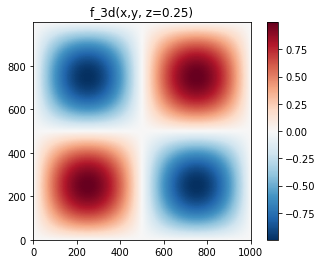

In [13]:
n_z = 1
plt.imshow(f_3d_interp[:,:,n_z])
plt.title('f_3d(x,y, z={:.2f})'.format(zinterp[n_z]))
plt.colorbar();

## RegularGridInterpolator (scipy.interpolate)

Appears to be the best of these options

In [14]:
f_3d_interp = RegularGridInterpolator((xgrid, ygrid, zgrid), f_3d_grid)

In [15]:
# Prepare the coordinates to evaluate the array on :
points_x, points_y, points_z = np.broadcast_arrays(xinterp.reshape(-1,1,1), yinterp.reshape(1,-1,1), zinterp)
coord = np.vstack((points_x.flatten(), # a weird formula !
                   points_y.flatten(),
                   points_z.flatten()
                   ))
coord.shape

(3, 5005000)

In [16]:
%%timeit # Interpolate
f_3d_interp_res = f_3d_interp(coord.T).reshape(len(xinterp), len(yinterp), len(zinterp))

2.87 s ± 21.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Analysis

[documentation](http://scipy.github.io/devdocs/generated/scipy.interpolate.RegularGridInterpolator.html)

actual interpolation code: https://github.com/scipy/scipy/blob/master/scipy/interpolate/interpolate.py#L1577 (pure Python, no Cython involved!)

API:

```RegularGridInterpolator(points, values, [...])```

- `points`: tuple of ndarray of float, with shapes _(m1, ), ..., (mn, )_.
→ The points defining the regular grid in n dimensions.
- `value`: array_like, shape _(m1, ..., mn, ...)_.
→ The data on the regular grid in n dimensions.

**Performance**
- 0.022 ms for instanciation, 116 ms for evaluation (1Mpts)
- in 1.8 s in 3D (5 Mpts)

### Input data

In [17]:
# Setup 3D datagrid
Ndata = 5
xgrid = np.linspace(0, 1, Ndata)
ygrid = np.linspace(0, 1, Ndata+1) # use a slighly different size to check differences
zgrid = np.linspace(0, 1, Ndata+2)

f_3d_grid = f_3d(xgrid.reshape(-1,1,1), ygrid.reshape(1,-1,1), zgrid)

### Train

In [18]:
# Define the grid to build the interpolator on:
Ninterp = 10
xinterp = np.linspace(0,1, Ninterp)
yinterp = np.linspace(0,1, Ninterp+1) # use a slighly different size to check differences
zinterp = np.linspace(0,1, 5) # small dimension to avoid size explosion

In [19]:
# Build the interpolator
%timeit f_3d_interp = RegularGridInterpolator((xgrid, ygrid, zgrid), f_3d_grid)

49.6 µs ± 181 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Evaluate

In [20]:
# Prepare the coordinates to evaluate the array on :
points_x, points_y, points_z = np.broadcast_arrays(xinterp.reshape(-1,1,1), yinterp.reshape(1,-1,1), zinterp)
coord = np.vstack((points_x.flatten(), # a weird formula !
                   points_y.flatten(),
                   points_z.flatten()
                   ))
coord.shape

(3, 550)

In [21]:
f_3d_interp(coord)

ValueError: The requested sample points xi have dimension 550, but this RegularGridInterpolator has dimension 3

In [ ]:
%timeit # Interpolate
#f_3d_interp_res = f_3d_interp(coord.T).reshape(len(xinterp), len(yinterp))
f_3d_interp(np.array([[0, 0, 0]]))

## Example 2

### Chebyshev grid

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def norm_chebyshev_grid(dimensions):
    """Returns a normalised Chebyshev grid of specified dimensions.
    
    list tuple dimensions: Tuple with (size, a, b) of each dimension
    
    Further reading: https://en.wikipedia.org/wiki/Chebyshev_nodes
    """
    #grid = [(-np.cos(np.pi * np.arange(dim) / (dim - 1))) for dim in dimensions]
    grid = [chebyshev_affine_transformation(n, a, b) for n, a, b in dimensions]
    return grid

def chebyshev_affine_transformation(n, a=-1, b=1):
    x_i = 0.5*(b + a) + 0.5*(b - a) * np.cos( np.pi * (np.arange(1, n + 1) - 0.5)/n)
    return x_i

In [ ]:
chebyshev_affine_transformation(-1, 1, 2)

In [ ]:
roots = np.polynomial.chebyshev.chebroots(np.eye(9)[-1])
roots/0.98078528

In [ ]:
 norm_chebyshev_grid([7])

### Setup data

In [ ]:
from scipy.interpolate import RegularGridInterpolator
# Define target function
def f(x,y,z):
    return 2 * x**3 + 3 * y**2 - z

In [ ]:
# Toy data
x = np.linspace(1, 4, 10)
x = [1, 2, 5, 12]
y = np.linspace(4, 7, 3)
z = np.linspace(7, 9, 3)
coords = np.meshgrid(x, y, z, indexing='ij', sparse=False)
data = f(*np.meshgrid(x, y, z, indexing='ij', sparse=True))

In [ ]:
# Chebyshev data
grid = norm_chebyshev_grid([10, 20, 5])
x, y, z = grid
coords = np.meshgrid(*grid, indexing='ij')
data = f(*coords)

In [ ]:
grid

In [ ]:
np.shape(data)

In [ ]:
data.flatten()[:10]

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[0], coords[1], coords[2], c=data.flatten()) #, marker=m)

### Perform Interpolation

In [ ]:
print(f'N points = {len(data.flatten())}')

In [ ]:
%timeit my_interpolating_function = RegularGridInterpolator((x, y, z), data)

In [ ]:
my_interpolating_function = RegularGridInterpolator((x, y, z), data)

In [ ]:
# Example format to feed interpolator - array of lists of dimension d
pts = np.array([[0.1, 0.2, 0.3], [0.3, 0.2, 0.1]])
my_interpolating_function(pts)

In [ ]:
interp_coords = [np.array((coords[0].flatten()[i], coords[1].flatten()[i], coords[2].flatten()[i])) for i, _ in enumerate(coords[0].flatten())]

In [ ]:
interp_coords[1]

In [ ]:
data_interp = np.array([my_interpolating_function(coord).tolist()[0] for coord in interp_coords])

In [ ]:
data_interp[:10]

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coords[0], coords[1], coords[2], c=data_interp) #, marker=m)

### Compare original to interpolation

In [ ]:
data_diff = data_interp - data.flatten()

In [ ]:
np.max(np.abs(data_diff))

## Toy example - Error estimate (l303.pdf)

In [ ]:
def runge_phen(x):
    return 1/(1 + 12*x*x)
import numpy as np

def gridpoints(n, a=-1, b=1):
    x = [0.5*(b + a) + 0.5*(b - a) * np.cos( (2*(i+1 - 1)*np.pi)/(2*(n + 1))) for i in np.arange(1, n + 1)]
    return sorted(x)
    
gridpoints(7, a=0, b=np.pi/2)

In [ ]:
x =  gridpoints(7)
data = [runge_phen(xi) for xi in x]
x

In [ ]:
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator
toy_interp = interp1d(x, data)

In [ ]:
errors = [toy_interp(xi) - runge_phen(xi) for xi in np.linspace(-0.9, 0.9, 100)]
max(errors)
# Expect max error = 0.2